# Feature Engineering to Reproduce Statistical Analyses 

In a complex and messy world where we can only observe so much through data, data cleaning and feature engineering are key steps in the data science pipeline to ensure predictive and generalizable models. Feature engineering allows us to imbue our dataset with context and structural information that can be invaluable. Practioners, Kaggle competition winners, and researchers all depend on good feature engineering for succesful machine learning pipelines.

A good general overview on the topic is available here: http://www.feat.engineering/

In this notebook we'll roughly reimplement the cleaning and analysis done in an economic paper on police auditing. This is an example of a simple and useful analysis that you could do with public data today and the tools you're currently learning in this class.

### Re-engineering the feature set and analysis of Goel et al 2016 "Precinct  Or  Prejudice?  Understanding  Racial Disparities  In  New  York  City’s  Stop-and-frisk  Policy"
https://5harad.com/papers/stop-and-frisk.pdf


New York's “Stop-and-Frisk” policy was eventually stopped for facilitating unconstitutional searches. Until that point, however, the police stopped and searched as many as 685,000 people per year. The vast majority of these stops were on Black and Hispanic people, who were 5 times less likely to actually have a weapon compared to their white counterparts. In this paper, the authors consider how many stops had effectively 0% chance of producing a weapon based on features observed before the stop. 

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_roc_curve, recall_score, precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# Downloading WILDS benchmark release https://wilds.stanford.edu/
! wget -nc https://worksheets.codalab.org/rest/bundles/0xea27fd7daef642d2aa95b02f1e3ac404/contents/blob/sqf.csv
data_df = pd.read_csv('sqf.csv')

--2021-09-20 16:10:48--  https://worksheets.codalab.org/rest/bundles/0xea27fd7daef642d2aa95b02f1e3ac404/contents/blob/sqf.csv
Resolving worksheets.codalab.org (worksheets.codalab.org)... 13.68.212.115
Connecting to worksheets.codalab.org (worksheets.codalab.org)|13.68.212.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/csv]
Saving to: ‘sqf.csv’

sqf.csv                 [   <=>              ] 340.14M  6.40MB/s    in 36s     

2021-09-20 16:11:26 (9.53 MB/s) - ‘sqf.csv’ saved [356662697]



#### Before we dive into the analysis we need to narrow the scope of stops and demographic attributes that we're interested in

In [4]:
# The dataset contains all types of police interactions.
# Here we're narrowing it down to fraught practices related New York's controversial stop and frisk policies
data_df = data_df[data_df['suspected.crime'] == 'cpw']

In [5]:
# Would it make sense to just drop samples with missing data?
print(f"Out of {data_df.shape[0]} total points, if we drop all with missing data \
we'll have {data_df.dropna().shape[0]} points ( or {data_df.dropna().shape[0]/data_df.shape[0]}\
of the original dataset")

Out of 621696 total points, if we drop all with missing data we'll have 8156 points ( or 0.013118952028000824of the original dataset


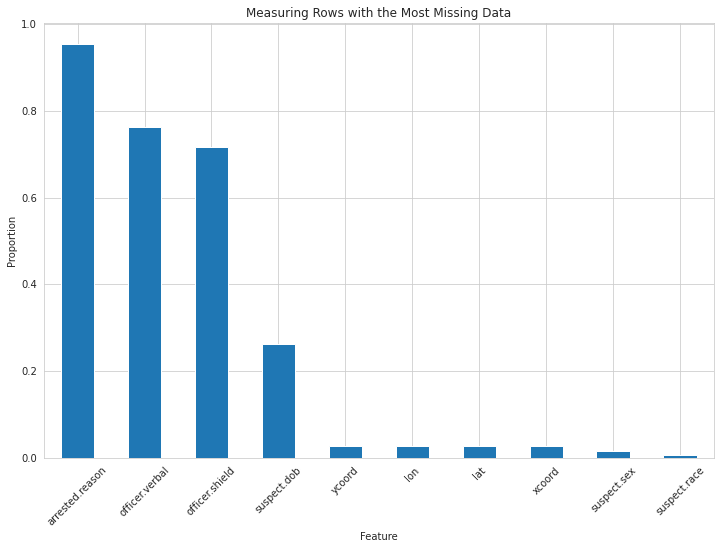

In [6]:
# What's missing?
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
missing_vals = data_df.isna().sum()/data_df.shape[0]
missing_vals = missing_vals.sort_values(ascending=False)[0:10]
ax = missing_vals.plot(kind='bar')

ax.set_title('Measuring Rows with the Most Missing Data')
ax.set_ylabel('Proportion')
ax.set_xlabel('Feature')
ax.tick_params(axis='x', rotation=45)

There are a mix of data types that are missing. Will this affect our analysis? Are the data missing in systematic ways?

*   Does it make sense that some of these are missing? 'arrested.reason' might, so long as most people aren't arrested. 
*  Suspect race and sex might be more problematic for our analysis, but most of the values are there
* What do officer.verbal and officer.shield represent? For now we'll exclude them, but how could we find out?
* xcoord and ycoord are real valued inputs. Should we include them as inputs to our model?


In [7]:
# What proportion of stops are arrests?
print(data_df.arrested.sum()/data_df.shape[0], " stops were arrests")

# What proportion of arrest reasons are we missing?
print(1- data_df['arrested.reason'].isna().sum()/data_df.shape[0],
      " have arrest reasons")

0.04613669703520692  stops were arrests
0.04610935248095527  have arrest reasons


We're going to remove racial categories with missing data or labels that the original paper doesn't consider. It seems like there are few enough points this should be OK, but we will need to highlight this in our final report.

In [8]:
# Following up on past work, the Goel paper chooses to only include black, hispanic, and white labels
categories = ['black', 'white hispanic', 'black hispanic', 'hispanic', 'white']
data_df = data_df.loc[data_df['suspect.race'].map(lambda x: x in categories)]
data_df['suspect.race'] = data_df['suspect.race'].map(lambda x: 'Hispanic' if 'hispanic' in x else x.title())

In [9]:
feats_to_use = []

feats_to_use += ['suspect.height', 'suspect.weight', 'suspect.age', 'observation.period',
                        'inside.outside', 'location.housing', 'radio.run', 'officer.uniform']
# Primary stop reasoning features
feats_to_use += [i for i in data_df.columns if 'stopped.bc' in i]
# Secondary stop reasoning features, if any
feats_to_use += [i for i in data_df.columns if 'additional' in i]

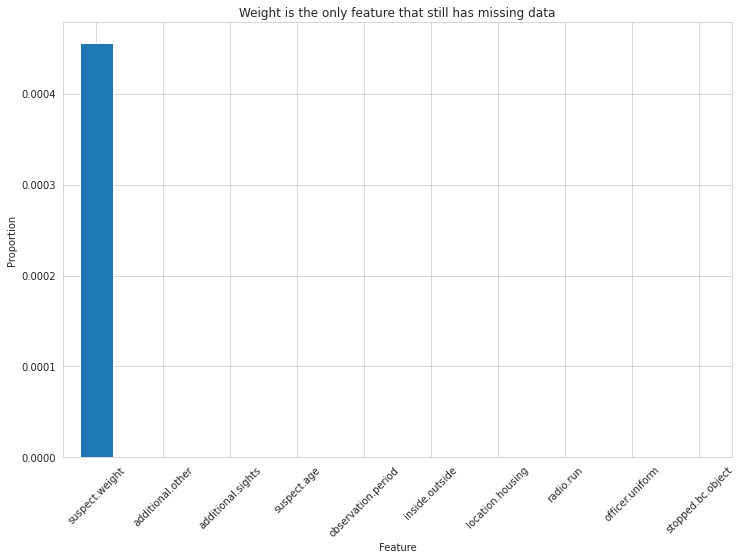

In [10]:
# What's still missing?
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
missing_vals = data_df[feats_to_use].isna().sum()/data_df.shape[0]
missing_vals = missing_vals.sort_values(ascending=False)[0:10]
ax = missing_vals.plot(kind='bar')

ax.set_title('Weight is the only feature that still has missing data')
ax.set_ylabel('Proportion')
ax.set_xlabel('Feature')
ax.tick_params(axis='x', rotation=45)

In [11]:
data_df = data_df.dropna(subset = feats_to_use)

In [12]:
# For validity, we'll need to do our time split
test_df =  data_df[data_df.year > 2010]
train_df = data_df[data_df.year <= 2010]

In [13]:
# Build validation set
def subsample_idxs(idxs, proportion, seed=4171):
  """Split a dataframe into two with training size proportion*len(idxs). Seed lets
  us get the same splits consistently"""
  rng = np.random.default_rng(seed)
  shuffled_idxs = idxs.copy()
  rng.shuffle(shuffled_idxs)
  train_size = int(proportion*len(shuffled_idxs))
  return idxs[:train_size], idxs[train_size:]

train_idxs, validation_idxs = subsample_idxs(train_df.index.tolist(), 0.8)

val_df = train_df[train_df.index.isin(validation_idxs)]
train_df = train_df[~train_df.index.isin(val_df.index)]


<class 'numpy.float64'>


Text(0.5, 0, 'Height (units?)')

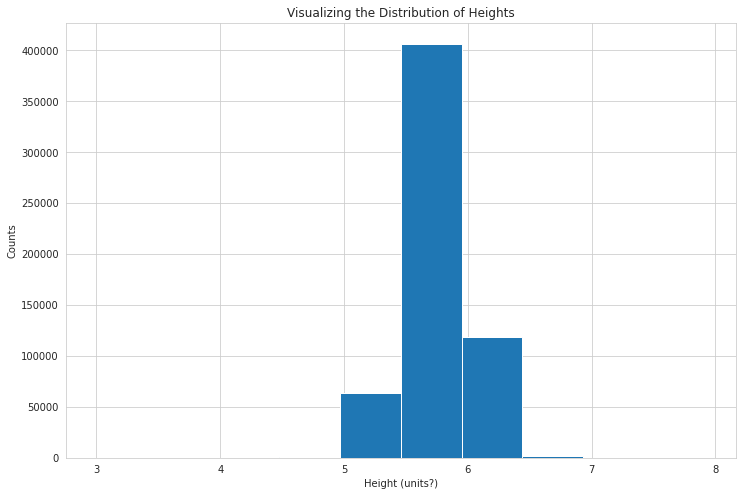

In [14]:
# Checks on data types? 
print(type(data_df['suspect.height'][0]))
ax = data_df['suspect.height'].hist(figsize=(12,8))
ax.set_title('Visualizing the Distribution of Heights')
ax.set_ylabel('Counts')
ax.set_xlabel('Height (units?)')

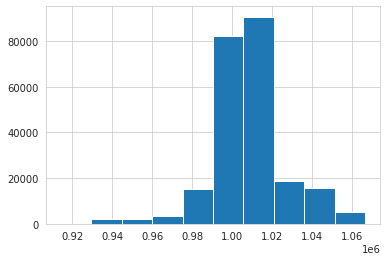

In [15]:
# What about location data?
train_df.xcoord.hist()

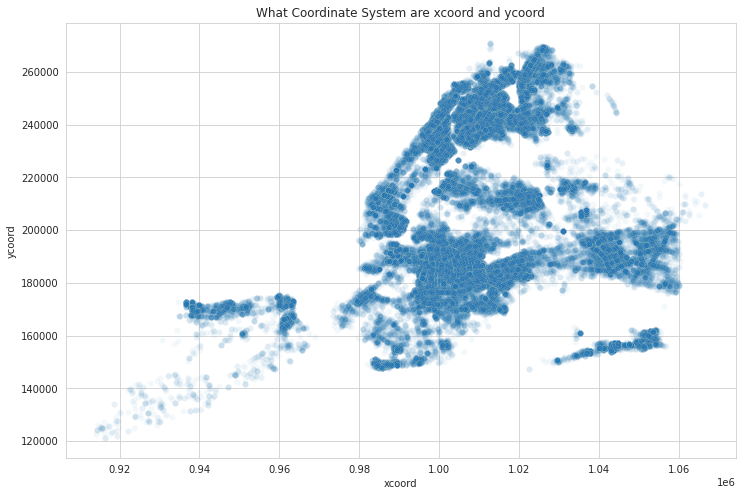

In [16]:
# Atititude and longitude? No - boroughs
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='xcoord', y='ycoord', data=train_df, alpha=0.05)

ax.set_title('What Coordinate System are xcoord and ycoord')
ax.set_ylabel('ycoord')
ax.set_xlabel('xcoord')
ax.tick_params(axis='x', rotation=0)

In [17]:
# From NYPD documents.
inverted_bor_dict = {'Manhattan' :
[1,5,6,7,9,10,13,17,19,20,23,24,25,26,28,30,32,33,34,14,18,22],
'Bronx':
[40,41,42,43,44,45,46,47,48,49,50,52],
'Brooklyn':
[60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94],
'Queens':
[100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115],
'Staten Island':
[120,121,122,123]}

bor_dict = {}
for k,v in inverted_bor_dict.items():
    for i in v:
        bor_dict[i]= k


def find_boroughs(df) -> list:
  """Loop through dataframe and return a list of labels"""
  return [bor_dict[int(i)] for i in df.precinct]

train_df['borough'] = find_boroughs(train_df)
val_df['borough'] = find_boroughs(val_df)
test_df['borough'] = find_boroughs(test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


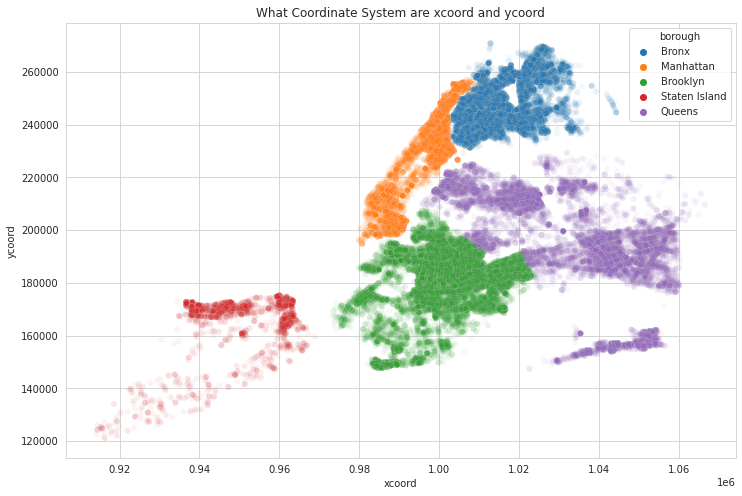

In [18]:
# Atititude and longitude? No - boroughs
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='xcoord', y='ycoord', data=train_df, alpha=0.05, hue='borough')
ax.set_title('What Coordinate System are xcoord and ycoord')
ax.set_ylabel('ycoord')
ax.set_xlabel('xcoord')
ax.tick_params(axis='x', rotation=0)

In [19]:
feats_to_use += ['borough']

In [20]:
# Normalize numeric features
columns_to_norm = ['suspect.height', 'suspect.weight', 'suspect.age', 'observation.period']
df_unnormed_train = train_df.copy()

def stand_columns(df, unnormed_train, columns_to_norm):
  """Standardizes features based on an unnormed training dataframe"""
  for feature_name in columns_to_norm:
                df[feature_name] = df[feature_name] - np.mean(unnormed_train[feature_name])
                df[feature_name] = df[feature_name] / np.std(unnormed_train[feature_name])
  return df

def norm_columns(df, unnormed_train, columns_to_norm):
  """Normalize features based on an unnormed training dataframe"""
  for feature_name in columns_to_norm:
                df[feature_name] = df[feature_name] - np.min(unnormed_train[feature_name])
                df[feature_name] = df[feature_name]/df[feature_name].max()
  return df

x_df = norm_columns(train_df, df_unnormed_train, columns_to_norm)
xv_df = norm_columns(val_df, df_unnormed_train, columns_to_norm)
xt_df = norm_columns(test_df, df_unnormed_train, columns_to_norm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [21]:
# Get one hot features and make sure they're consistent
dummy_feats = feats_to_use + ['found.weapon']
x_df = pd.get_dummies(x_df[dummy_feats])
new_feats = x_df.columns

xv_df = pd.get_dummies(xv_df[dummy_feats])
xv_df = xv_df[new_feats]

xt_backup = xt_df.copy() # For later analysis
xt_df = pd.get_dummies(xt_df[dummy_feats])
xt_df = xt_df[new_feats]

In [22]:
new_feats = [i for i in new_feats if i != 'found.weapon']

In [23]:
xv_df[new_feats]

,suspect.height,suspect.weight,suspect.age,observation.period,inside.outside,radio.run,officer.uniform,stopped.bc.object,stopped.bc.desc,stopped.bc.casing,stopped.bc.lookout,stopped.bc.clothing,stopped.bc.drugs,stopped.bc.furtive,stopped.bc.violent,stopped.bc.bulge,stopped.bc.other,additional.report,additional.investigation,additional.proximity,additional.evasive,additional.associating,additional.direction,additional.highcrime,additional.time,additional.sights,additional.other,location.housing_housing,location.housing_neither,location.housing_transit,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
254347,0.525424,0.227106,0.271429,0.003333,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,0,1,0,0,0,0,1,0
254348,0.576271,0.207570,0.328571,0.010000,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,0,1,0,0,1,0,0,0
254349,0.559322,0.219780,0.142857,0.006667,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,0,1,0,0,1,0,0,0
254350,0.542373,0.195360,0.171429,0.006667,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,True,True,True,True,True,False,False,0,1,0,0,1,0,0,0
254351,0.576271,0.244200,0.057143,0.003333,False,False,False,True,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318007,0.525424,0.158730,0.100000,0.003333,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,0,1,0,0,0,0,1,0
318008,0.508475,0.170940,0.100000,0.003333,True,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,1,0,0,0,0,1,0,0
318009,0.525424,0.183150,0.100000,0.003333,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,0,1,0,0,0,0,1,0
318010,0.559322,0.183150,0.142857,0.003333,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,0,1,0,0,0,0,1,0


In [40]:
poly = PolynomialFeatures(2)
x = poly.fit_transform(x_df[new_feats])
xv = poly.fit_transform(xv_df[new_feats])
xt = poly.fit_transform(xt_df[new_feats])
features = poly.get_feature_names(x_df.columns)

In [41]:
# Fit model
clf = SGDClassifier(fit_intercept=False, class_weight='balanced', loss='log', 
                         penalty='l2', verbose=False, max_iter=1000, warm_start=True)
clf.fit(x, x_df['found.weapon'])
clf.score(x, x_df['found.weapon'])

0.8643930502058157

<Figure size 360x360 with 0 Axes>

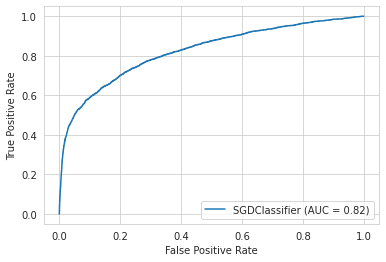

In [26]:
# Does the model seem reasonable?
plt.figure(figsize=(5,5))
ax = plot_roc_curve(clf, xv, xv_df['found.weapon'])

In [27]:
def pred_at_20(clf, x):
  return clf.predict_proba(x)[:, 1] >= 0.80

# groupwise_performance
def get_group_feats(X, Y, backup_df, group):
  """Return numpy feature matrix and label array for selected group"""
  df = backup_df.copy()
  df.reset_index(inplace=True)
  df = df[df['suspect.race'] == group]
  idxs = df.index.values
  return X[idxs, :], Y[idxs]

Y = xt_backup['found.weapon'].values

results = {}
for group in ['White', 'Black', 'Hispanic']:
  x_group, y_group = get_group_feats(xt, Y, xt_backup, group)
  preds = pred_at_20(clf, x_group)
  perf = precision_score(y_group, preds)
  results[f"{group} New Yorkers"] = perf

In [28]:
results = pd.DataFrame(results.items(), columns = ['Group', 'Proportion of Weapon Searches Resulting in a Weapon'])


Text(0.5, 0.9, 'Even though this is the top quintile for likely pedestrians, Black and Hispanic New Yorkers \n are still much less likely to actually have a weapon.')

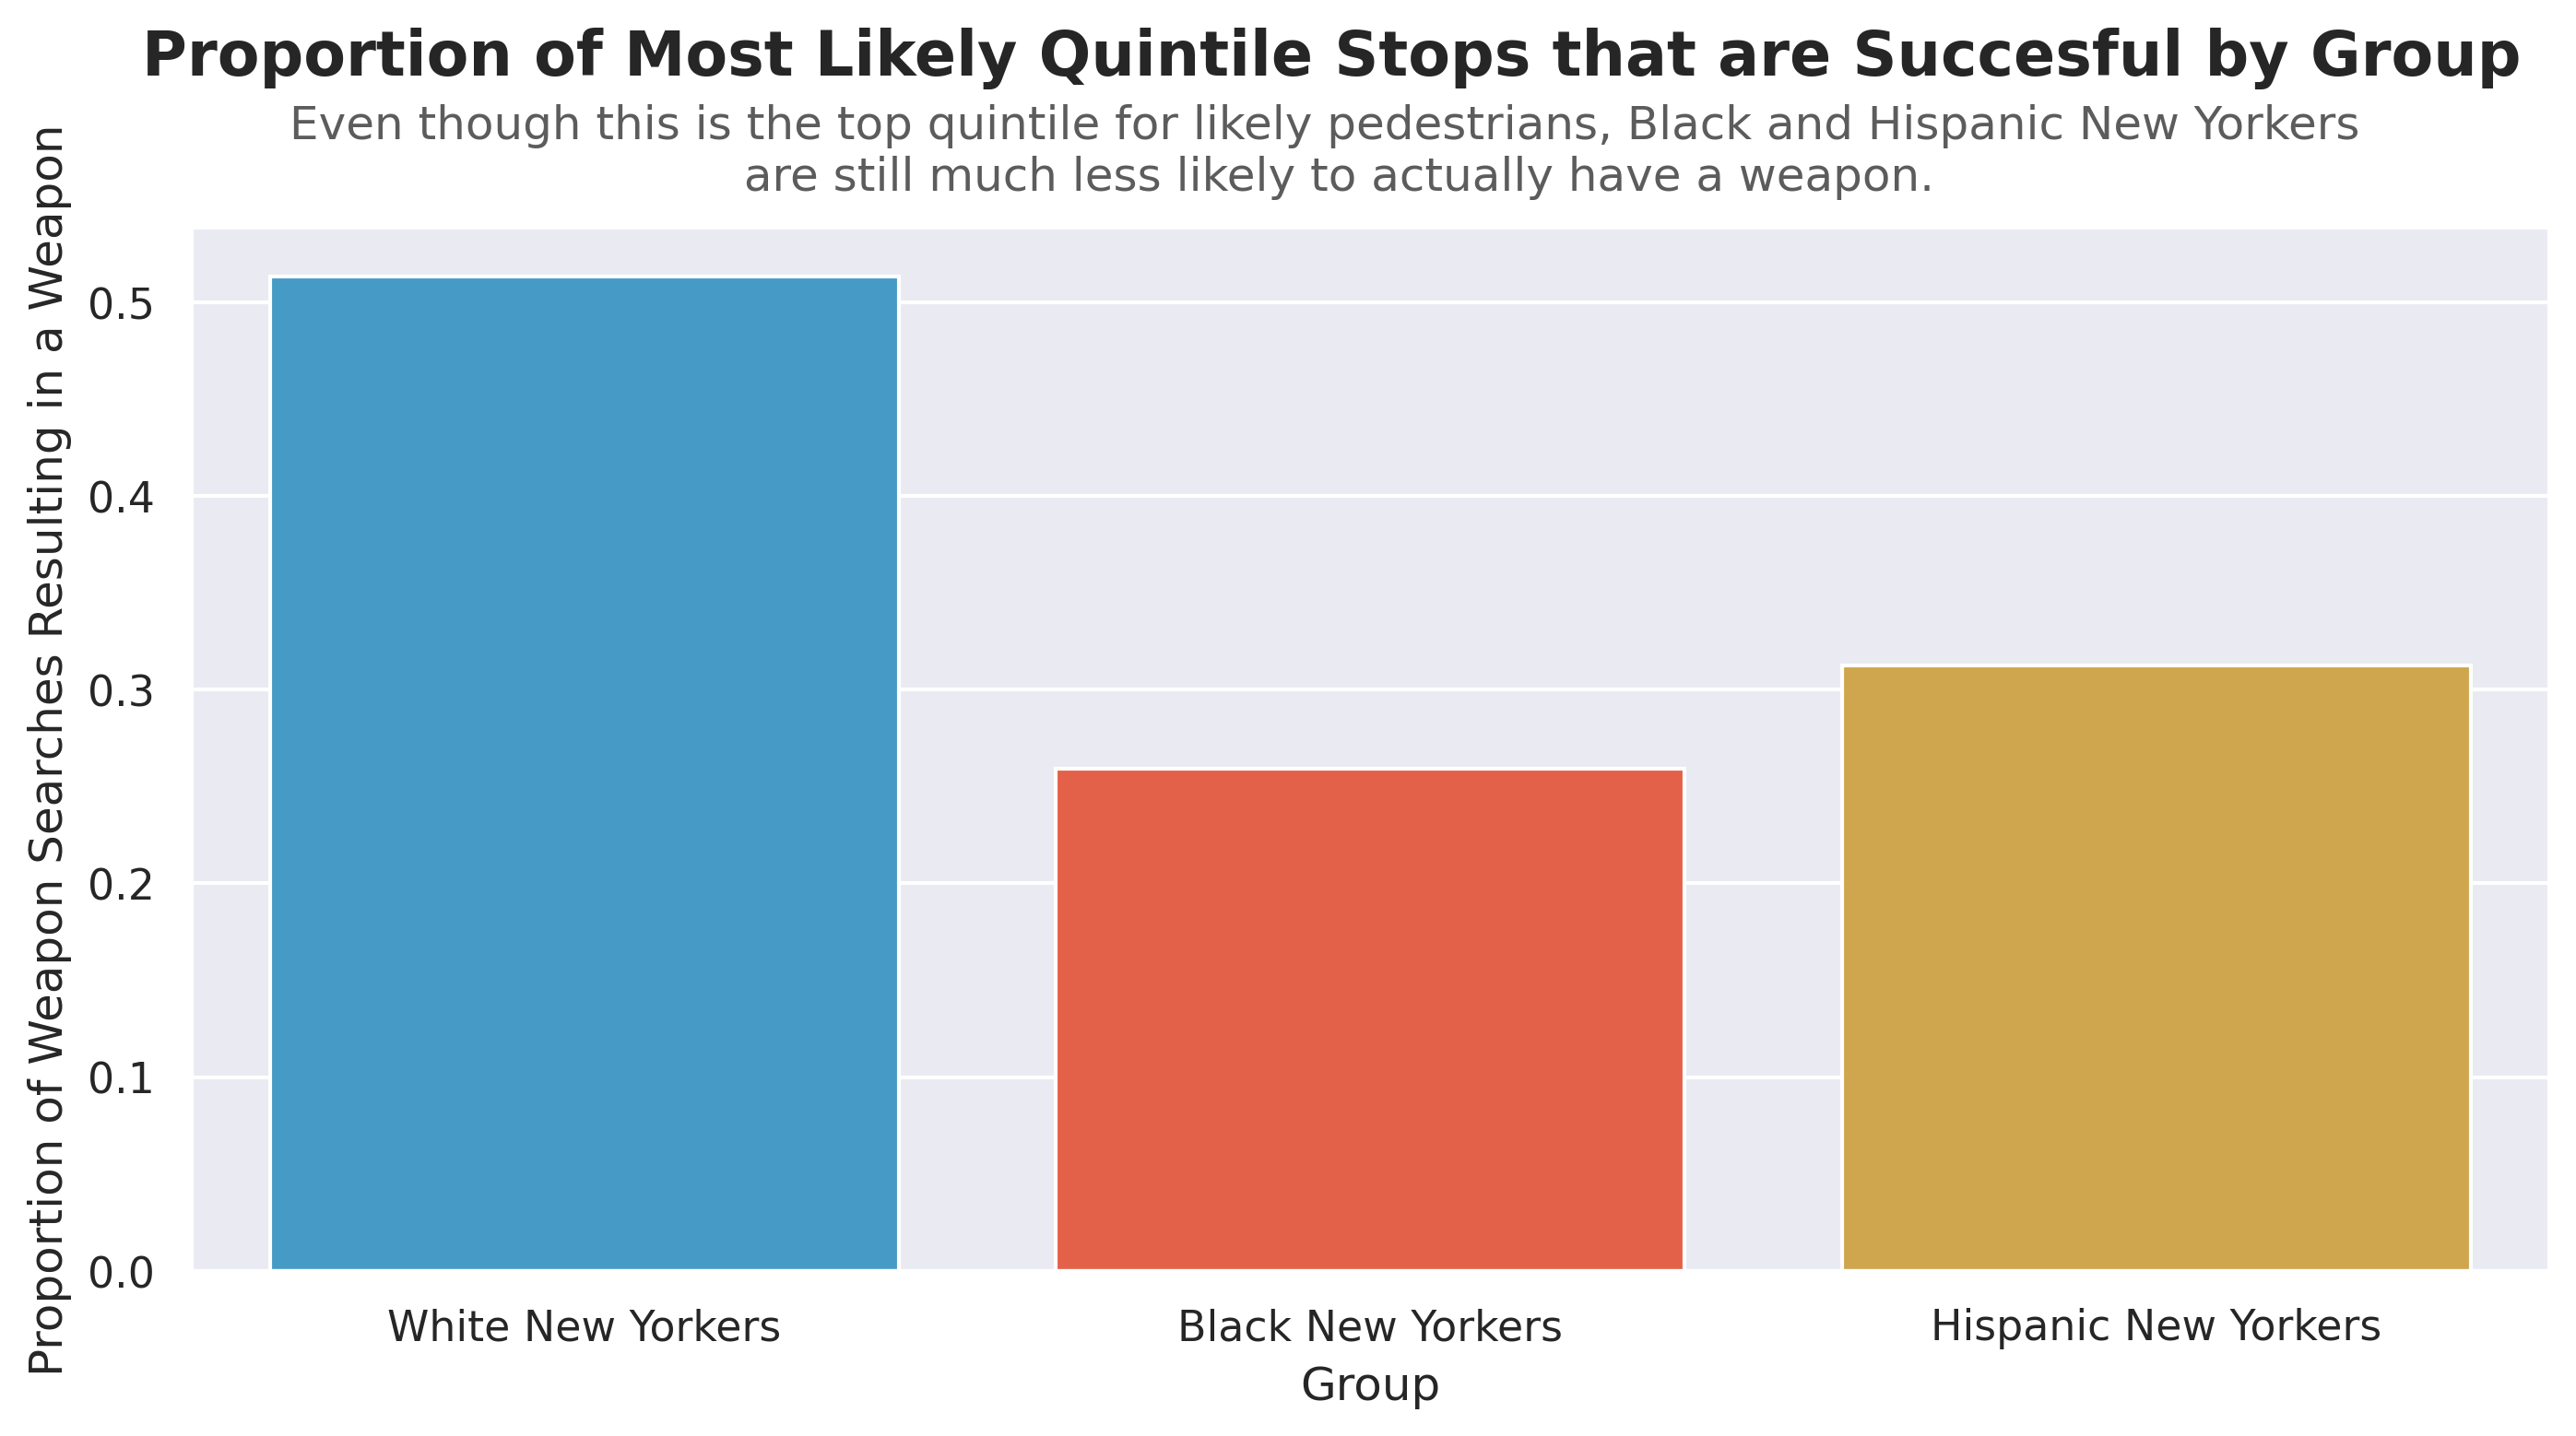

In [30]:

mpl.rcParams['figure.dpi'] = 300

scheme = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
]

sns.set_palette(scheme) # https://gist.github.com/zachwill/d5190af1a7f455dea45d
sns.set(font_scale=1)
fig, ax = plt.subplots( figsize=(11, 5))
ax = sns.barplot(x='Group', y='Proportion of Weapon Searches Resulting in a Weapon',
                 data=results, ax = ax, palette = scheme)

ax.tick_params(axis='x', rotation=0)

fig.text(x=.5, y=.98, s='Proportion of Most Likely Quintile Stops that are Succesful by Group', fontsize=16, weight='bold', ha='center', va='bottom')
fig.text(x=.5, y=.90, alpha=0.75, s='Even though this is the top quintile for likely pedestrians, Black and Hispanic New Yorkers \n are still much less likely to actually have a weapon.', ha='center', fontsize=12, va='bottom')
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


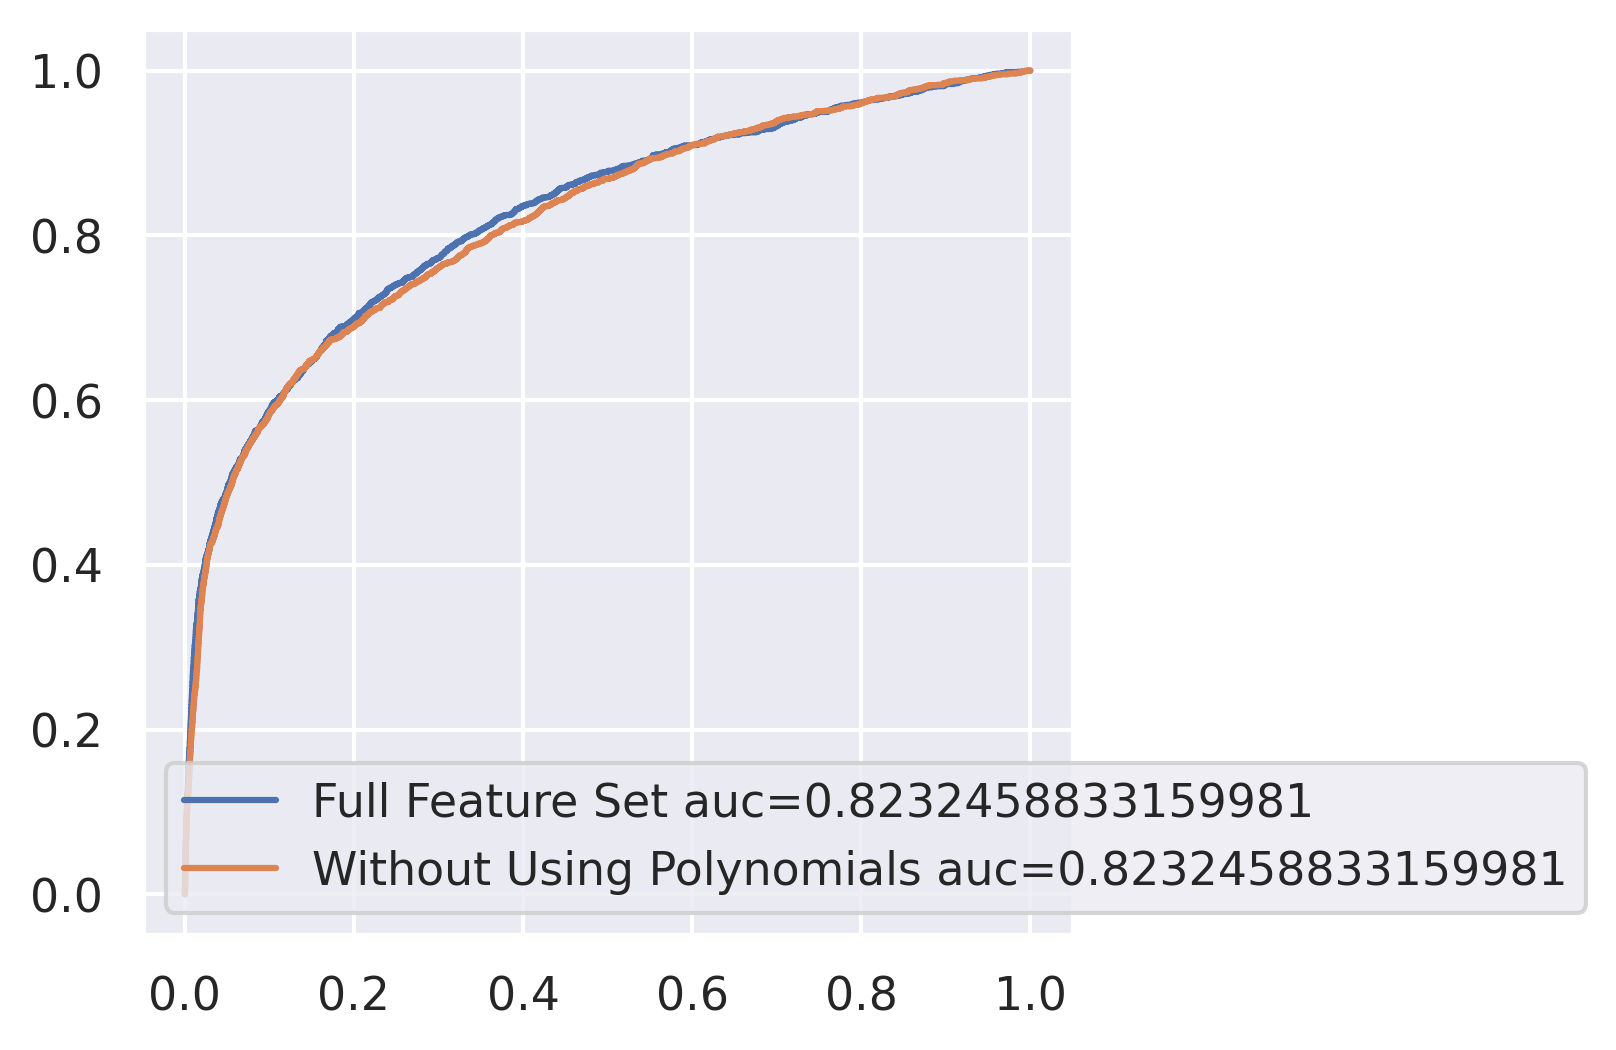

In [50]:
# Does the model seem reasonable?
poly = PolynomialFeatures(2)
x = poly.fit_transform(x_df[new_feats])
xv = poly.fit_transform(xv_df[new_feats])


plt.figure(figsize=(4,4))
preds = clf.predict_proba(xv)[:, 1]
fpr, tpr, thresh = roc_curve( xv_df['found.weapon'], preds)
auc = roc_auc_score(xv_df['found.weapon'], preds)
plt.plot(fpr,tpr,label="Full Feature Set auc="+str(auc))

poly = PolynomialFeatures(1)
x = poly.fit_transform(x_df[new_feats])
xv = poly.fit_transform(xv_df[new_feats])
features = poly.get_feature_names(x_df.columns)
# Fit model
clf2 = SGDClassifier(fit_intercept=False, class_weight='balanced', loss='log', 
                         penalty='l2', verbose=False, max_iter=1000, warm_start=True)
clf2.fit(x, x_df['found.weapon'])
clf2.score(x, x_df['found.weapon'])

preds = clf2.predict_proba(xv)[:, 1]

fpr, tpr, thresh = roc_curve(xv_df['found.weapon'], preds)


plt.plot(fpr,tpr,label="Without Using Polynomials auc="+str(auc))
plt.legend()


In [ ]:
# encoding missingness? 
# http://www.feat.engineering/encoding-missingness.html

In [51]:
# Uncomment for some bonus plotting! 
# def pred_at_z(clf, x, z):
#   """Predict at an arbitrary threshold"""
#   return clf.predict_proba(x)[:, 1] >= z

# # groupwise_performance
# def get_group_feats(X, Y, backup_df, group):
#   """Return numpy feature matrix and label array for selected group"""
#   df = backup_df.copy()
#   df.reset_index(inplace=True)
#   df = df[df['suspect.race'] == group]
#   idxs = df.index.values
#   return X[idxs, :], Y[idxs]

# Y = xt_backup['found.weapon'].values

# results = []
# for group in ['White', 'Black', 'Hispanic']:
#   x_group, y_group = get_group_feats(xt, Y, xt_backup, group)
#   preds = clf.predict_proba(x_group)[:, 1]
#   for i in np.linspace(0, 1, 100):
#     perf = precision_score(y_group, preds >= i)
#     results.append([f"{group} New Yorkers", perf, i])

# ax =sns.lineplot(data=pd.DataFrame(results, columns=['Group', 'Precision', 'Threshold']),
#              hue='Group', x= 'Threshold', y='Precision', palette = scheme)
# ax.invert_xaxis()